In [59]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, SelectKBest, f_classif,chi2, VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Algorithm Imports
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )

In [60]:
data = pd.read_csv('Credit Card Fraud.csv')

In [61]:
data

,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,location,personal_status,other_parties,...,property_magnitude,cc_age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


### Exploratory Data Analysis

In [62]:
ds = data.copy()

In [63]:
# Clean the Ovr_Draft feature
ds['over_draft'] = ds['over_draft'].replace({'no checking': 'unchecked', '<0': 'no', '0<=X<200': 'no', '>=200' : 'yes'})

# Clean the Credit History feature
ds['credit_history'] = ds['credit_history'].replace({'critical/other existing credit':'critical','delayed previously':'delayed',
                        'no credits/all paid': 'all paid', 'existing paid': 'all paid'})

# Clean the Average_Credit_Balance feature
ds['Average_Credit_Balance'] = ds['Average_Credit_Balance'].replace({'<100':'below_100', 'no known savings': 'no_savings',
                           '100<=X<500': 'below_500', '500<=X<1000': 'below_1000', '>=1000':'above_1000' })

# Clean the employment feature
ds['employment'] = ds['employment'].replace({'1<=X<4':'employed','>=7':'employed', '4<=X<7': 'employed', '<1':'unemployed'}) 


# Split the personal_status feature into two columns
ds[['gender', 'marital_status']] = ds['personal_status'].str.split(pat = " ",expand = True)
# Drop Marital status as no clear feature could be gotten
ds.drop(['marital_status', 'residence_since'],inplace =True, axis = 1)


ds['job'] = ds['job'].replace({'unskilled resident': 'unskilled', 'high qualif/self emp/mgmt': 'self_employed',
                                'unemp/unskilled non res': 'unemeployed'})

# Rename columns
ds.rename({'cc_age': 'age'},axis = 1, inplace = True)

# Change the age feature location
gender_col = ds.pop('gender')
ds.insert(9, 'gender', gender_col)

ds.drop(['personal_status', 'location'], inplace = True, axis = 1)
ds

,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,gender,other_parties,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,no,6,critical,radio/tv,1169,no_savings,employed,male,none,real estate,67,none,own,2,skilled,1,yes,yes,good
1,no,48,all paid,radio/tv,5951,below_100,employed,female,none,real estate,22,none,own,1,skilled,1,none,yes,bad
2,unchecked,12,critical,education,2096,below_100,employed,male,none,real estate,49,none,own,1,unskilled,2,none,yes,good
3,no,42,all paid,furniture/equipment,7882,below_100,employed,male,guarantor,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,no,24,delayed,new car,4870,below_100,employed,male,none,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,unchecked,12,all paid,furniture/equipment,1736,below_100,employed,female,none,real estate,31,none,own,1,unskilled,1,none,yes,good
996,no,30,all paid,used car,3857,below_100,employed,male,none,life insurance,40,none,own,1,self_employed,1,yes,yes,good
997,unchecked,12,all paid,radio/tv,804,below_100,employed,male,none,car,38,none,own,1,skilled,1,none,yes,good
998,no,45,all paid,radio/tv,1845,below_100,employed,male,none,no known property,23,none,for free,1,skilled,1,yes,yes,bad


In [64]:
ds.describe()

,credit_usage,current_balance,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,11.375469,0.577654,0.362086
min,4.000000,250.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,75.000000,4.000000,2.000000


### Explanatory Analysis

###### UniVariate Analysis

In [65]:
import plotly.figure_factory as ff

corrs = ds.corr()
fig_heatmap = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
fig_heatmap.update_layout(title= 'Correlation of whole Data',  
                 plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Muli, sans-serif"),
                        font=dict(color='#8a8d93'))

Features are not overly correlated for concern

In [66]:
dc = px.histogram(data, x='credit_history',
                         title='Customers Credit History', height=450,
                         color_discrete_sequence=['#03DAC5'],
                         )
dc.update_xaxes(categoryorder='total descending')

dc.update_layout(margin=dict(t=70, b=10, l=70, r=40),
                        # hovermode="x unified",
                        # xaxis_tickangle=360,
                        xaxis_title=' Credit History ', yaxis_title=" Counts ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Muli, sans-serif"),
                        font=dict(color='#8a8d93'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
dc

Here we see that most of the customers have loans that are paid <br>
Lesser than a 100 has previously delayed loan <br>
Very few has all their loans paid <br>
Less than 50 has no credits at all

In [67]:
pup = px.histogram(data, x='purpose',
                         title='Purpose for Collection of Loan', height=400,
                         color_discrete_sequence=['#03DAC5'],
                         )
pup.update_xaxes(categoryorder='total descending')

pup.update_layout(margin=dict(t=70, b=10, l=70, r=40),
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Muli, sans-serif"),
                        font=dict(color='#8a8d93'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
pup

In [68]:
# Bin Current Balance to have a range

dz = data.copy()
dz['binned'] = pd.cut(x = data['current_balance'], bins = [1, 500, 1000, 3000, 5000, 8000, 10000, 13000, 15000, 18500], 
                    labels = ['1 - 500', '500 - 1000', '1000-3000', '3000-5000', '5000-8000', '8000-10000',
                     '10000-13000', '13000-15000', '15000-185000'])

pup = px.histogram(data, x= dz['binned'],
                         title='Current Balance of Customers', height=400,
                         color_discrete_sequence=['#03DAC5'],
                         )
pup.update_xaxes(categoryorder='total descending')

pup.update_layout(margin=dict(t=70, b=10, l=70, r=40),
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title='Balance', yaxis_title="Count ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        # title_font=dict(size=25, color='#a5a7ab', family="Muli, sans-serif"),
                        font=dict(color='#9a8d93'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
pup

High income customers on the list are very low
Customers earning between 1000-3000 are most
Extremely low incme earners o the list are very low

In [69]:
pup = px.histogram(ds, x='Average_Credit_Balance',
                         title='Average_Credit_Balance', height=450,
                         color_discrete_sequence=['#03DAC5'],
                         )
pup.update_xaxes(categoryorder='total descending')

pup.update_layout(margin=dict(t=70, b=10, l=70, r=40),
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Muli, sans-serif"),
                        font=dict(color='#8a8d93'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
pup

Most customers have an average available balance of $100

Most of customer invest in cars than they do other investment> Followed by real estate

In [70]:
pup = px.histogram(ds, x= 'job',
                         title='Empployment Status', height=400, width = 450)
pup

larger number of the customers are skilled workers, followed by unskilled workers, self employed, then unemployed

##### BiVariate Analysis

c:\Users\BIOLA\Desktop\Data Science Projects\Learnings\Credit Fraud Detection\fraud_ENV\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



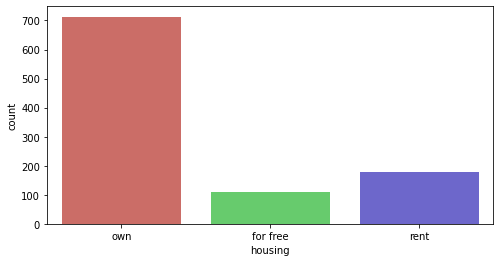

In [71]:
plt.figure(figsize=(8,4))
sns.countplot(ds['housing'], palette= 'hls')
# plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:xlabel='gender', ylabel='Count'>

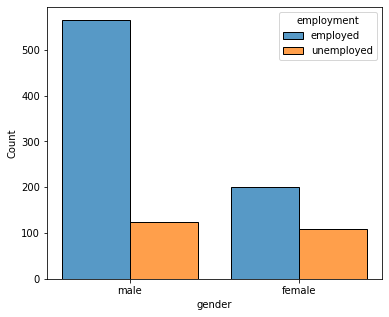

In [72]:
plt.figure(figsize=(6,5))
sns.histplot(data = ds, x = 'gender', hue = 'employment', multiple = 'dodge', shrink = .8)

There are more employed male than there are females

<AxesSubplot:xlabel='purpose', ylabel='Count'>

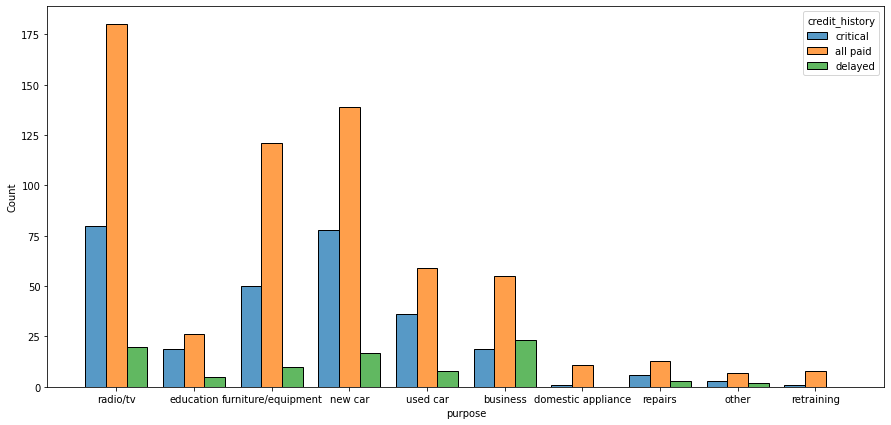

In [73]:
plt.figure(figsize=(15,7))
sns.histplot(data = ds, x = 'purpose', hue = 'credit_history', multiple = 'dodge', shrink = .8)

- Tendency of repayment is high on Radio/TV loan. Loan repayment for this purpose is also barely delayed.
- Tendency of repayment is very low on repairs, used car, and other unspecified loans. It is critical on Education loans.
- Tendency of repayment is also high on Equipment loan.
Altogether, radio/tv is the best loan purpose based on high repayment history

<AxesSubplot:xlabel='job', ylabel='Count'>

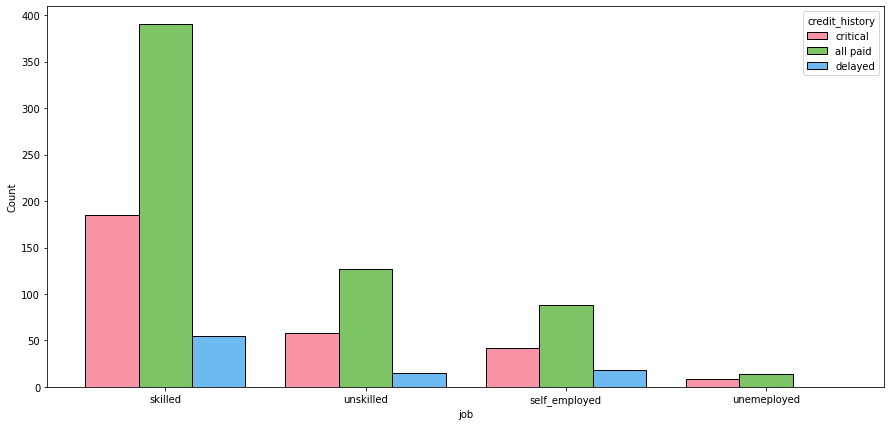

In [74]:
plt.figure(figsize=(15,7))
sns.histplot(data = ds, x = 'job', hue = 'credit_history', multiple = 'dodge', shrink = .8, palette= 'husl')

- Skilled workers has high chance of repayment on loans
- Unemployed has the least repayment tendency. 

[Text(0.5, 1.0, 'Access to Overdraft')]

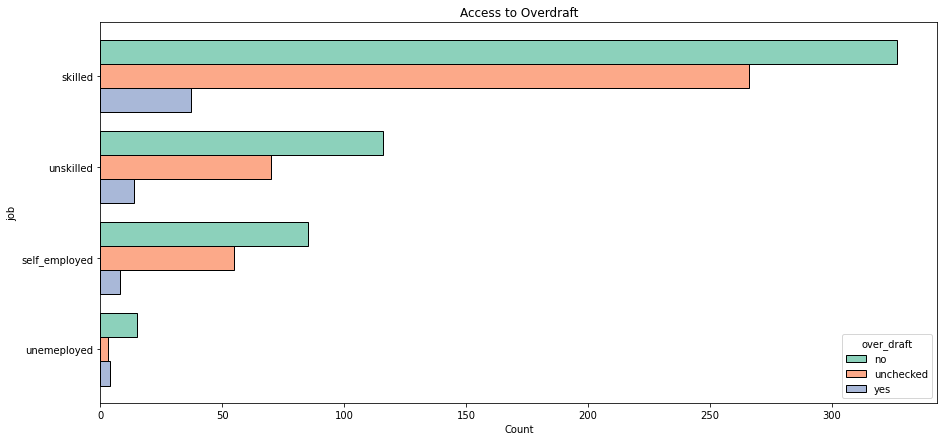

In [75]:
plt.figure(figsize=(15,7))
sns.histplot(data = ds, y = 'job', hue = 'over_draft', multiple = 'dodge', shrink = .8, palette= 'Set2').set(title ='Access to Overdraft')

[Text(0.5, 1.0, 'Age grade and Overdraft')]

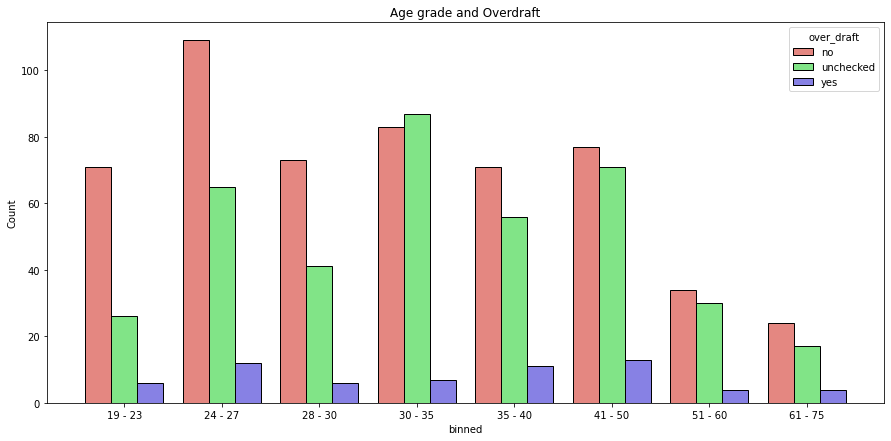

In [76]:
# Bin Current Balance to have a range

dz = data.copy()
dz['binned'] = pd.cut(x = ds['age'], bins = [19, 23, 27, 30, 35, 40, 50, 60, 75], 
                    labels = ['19 - 23', '24 - 27', '28 - 30', '30 - 35', '35 - 40', '41 - 50', '51 - 60', '61 - 75'])

plt.figure(figsize=(15, 7))
sns.histplot(data = dz, x= 'binned', hue = ds['over_draft'], multiple = 'dodge', 
                shrink = .8, palette= 'hls').set(title ='Age grade and Overdraft')


A larger percentage is unchecked. But then we can pertinently say age grade 41-50 takes more overdraft

[Text(0.5, 1.0, 'Age grade and Average Credit Balance')]

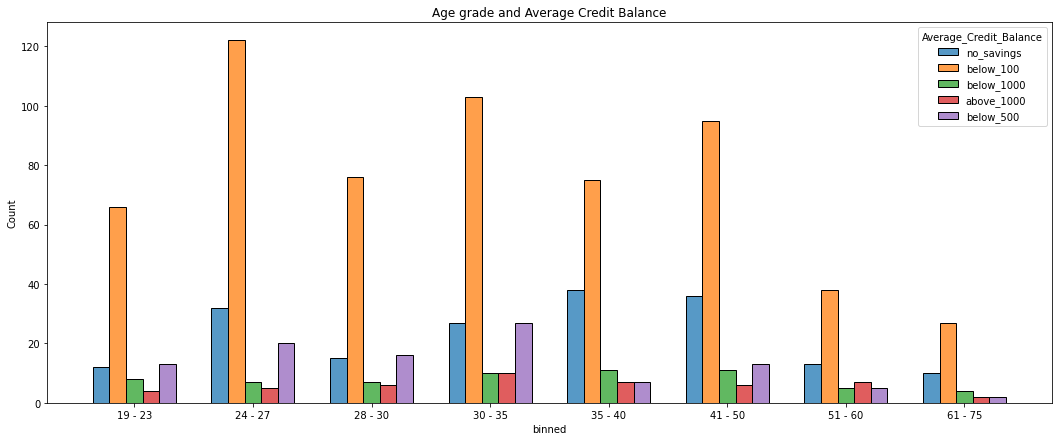

In [77]:
plt.figure(figsize=(18, 7))
sns.histplot(data = dz, x= 'binned', hue = ds['Average_Credit_Balance'], multiple = 'dodge', 
                shrink = .7).set(title ='Age grade and Average Credit Balance')

[Text(0.5, 1.0, 'Credit Balance and Property Ownership')]

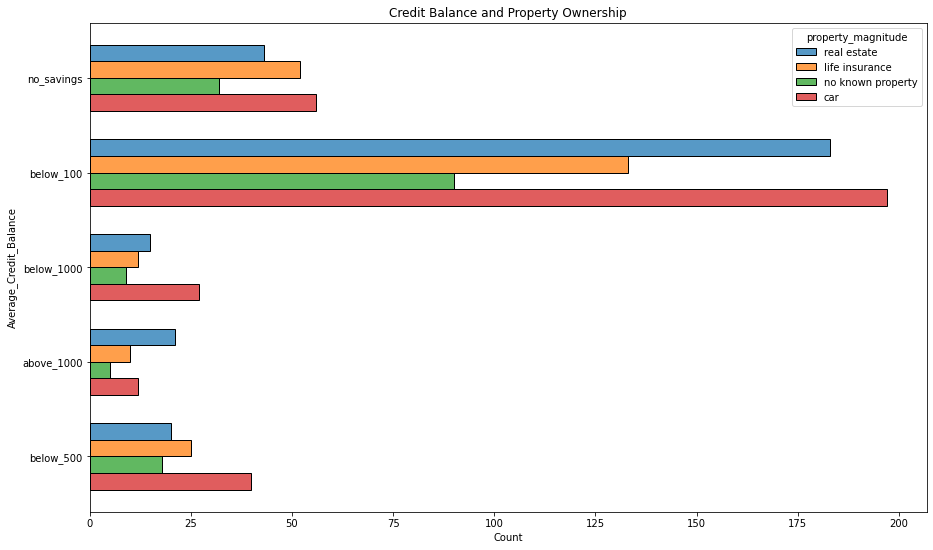

In [78]:
plt.figure(figsize=(15, 9))
sns.histplot(data = ds, y= 'Average_Credit_Balance', hue = 'property_magnitude', multiple = 'dodge', 
                shrink = .7).set(title ='Credit Balance and Property Ownership')

- Customers that has credit balance below $100 has the highest ownership of cars, real estate, and real estate

---------------------------------------------------- 
<h2 style='font-family:rockwell; color:#09917e'> Feature  Preprocessing and Selection

In [351]:
df = ds.copy()

# Find the number of unique values in each categorical feature
from enum import unique # Import unique library from enum

cat = df.select_dtypes(include = 'object').columns.tolist()
for i in df[cat]:
    print(i,":", len(df[cat][i].unique()))

over_draft : 3
credit_history : 3
purpose : 10
Average_Credit_Balance : 5
employment : 2
gender : 2
other_parties : 3
property_magnitude : 4
other_payment_plans : 3
housing : 3
job : 4
own_telephone : 2
foreign_worker : 2
class : 2


In [342]:
cate = df.select_dtypes(exclude = 'object').columns.tolist()
cate

['credit_usage',
 'current_balance',
 'age',
 'existing_credits',
 'num_dependents']

In [352]:
# oridinal Encode Categorical Features for feature selection process
encode = OrdinalEncoder(handle_unknown='error', unknown_value=None)

for i in [cat]:
    df[i] = encode.fit_transform(df[i])
df.head(3)

,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,gender,other_parties,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,0.0,6,1.0,6.0,1169,4.0,0.0,1.0,2.0,3.0,67,1.0,1.0,2,1.0,1,1.0,1.0,1.0
1,0.0,48,0.0,6.0,5951,1.0,0.0,0.0,2.0,3.0,22,1.0,1.0,1,1.0,1,0.0,1.0,0.0
2,1.0,12,1.0,2.0,2096,1.0,0.0,1.0,2.0,3.0,49,1.0,1.0,1,3.0,2,0.0,1.0,1.0


In [353]:
X = df.drop(['class'], axis = 1)
y = df['class']
len(X.columns)

18

In [212]:
# ANOVA F-value between label/feature
best_feature1 = SelectKBest(score_func = f_classif, k = 18)
fitting1 = best_feature1.fit(X,y)
scores1 = pd.DataFrame(fitting1.scores_)
columns1 = pd.DataFrame(X.columns)
feat_score1 = pd.concat([columns1, scores1], axis = 1)
feat_score1.columns = ['Feature', 'F_classif_score'] 
k1 = feat_score1.nlargest(18, 'F_classif_score')


# Chi-squared stats of non-negative features
best_feature2 = SelectKBest(score_func = chi2, k = 18)
fitting2 = best_feature2.fit(X,y)
scores2 = pd.DataFrame(fitting2.scores_)
columns2 = pd.DataFrame(X.columns)
feat_score2 = pd.concat([columns2, scores2], axis = 1)
feat_score2.columns = ['Feature', 'Chi2_score'] 
k2 = feat_score2.nlargest(18, 'Chi2_score')

# Concat both score into a frame for comparism
table = k1.merge(k2, how = 'inner', on = 'Feature')
table.sort_values(by = 'Chi2_score', ascending = False)

,Feature,F_classif_score,Chi2_score
2,current_balance,24.482366,58262.490007
1,credit_usage,48.333790,321.030795
0,over_draft,93.005766,61.575092
7,age,8.356995,30.200309
3,purpose,19.418505,24.924855
5,credit_history,13.647085,12.225505
4,employment,13.975775,10.578755
6,Average_Credit_Balance,11.719405,10.341673
10,property_magnitude,3.086847,3.259259
9,gender,5.720350,1.766736


In [382]:
# List out the selected columns based on Feature Elimination Criteria
sel_cols = ['current_balance', 'credit_usage', 'over_draft', 'age', 'purpose', 'credit_history', 
            'employment', 'Average_Credit_Balance', 'property_magnitude', 'gender', 'foreign_worker',
            'other_payment_plans', 'existing_credits']
X = ds[sel_cols]
y = ds['class']

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 56)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print('y_train: {}'.format(y_train.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (800, 13)
X_test: (200, 13)
y_train: (800,)
y_test: (200,)


-------------------------------- ---------------------------------------------------
<h2 style='font-family:rockwell; color:#59917e'> Pipeline Modelling 

In [385]:
# Data Preprocessing with Standard scaler
# Reduce Dimensinaltiy
# Apply Classifier (Logistic Regression, Random Forest, SVM, Naive Bayes)

pipeline_rf = Pipeline([('encoding1', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler1', StandardScaler(with_mean=False)),
                    ('classifier1', RandomForestClassifier())
])

In [386]:
pipeline_lr = Pipeline([('encoding2', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler2', StandardScaler(with_mean=False)),
                    ('classifier2', LogisticRegression())
])

In [387]:
pipeline_svc = Pipeline([('encoding3', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler3', StandardScaler(with_mean = False)),
                    ('classifier3', SVC())
])

In [388]:
pipeline_nb = Pipeline([('encoding4', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler4', StandardScaler(with_mean=False)),
                    ('classifier4', GaussianNB())
])

In [389]:
# Create a list of the pipeline
pipelines = [pipeline_rf, pipeline_lr, pipeline_svc, pipeline_nb]

# Create a dictionary of Pipelines for ease of reference 
pipe_dict = {0: 'Random Forest', 1: 'Logistic Regression', 2: 'Support Vector', 3: 'Naive Bayesian'}

In [390]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [391]:
# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [392]:
for i, model in enumerate(pipelines):
    print(f'\n{pipe_dict[i]} Training Accuracy: {model.score(X_train, y_train)}')


Random Forest Training Accuracy: 1.0

Logistic Regression Training Accuracy: 1.0

Support Vector Training Accuracy: 0.98

Naive Bayesian Training Accuracy: 0.97625


In [393]:
for i, model in enumerate(pipelines):
    print(f'\n{pipe_dict[i]} Test Accuracy: {model.score(X_test, y_test)}')


Random Forest Test Accuracy: 0.7

Logistic Regression Test Accuracy: 0.655

Support Vector Test Accuracy: 0.7

Naive Bayesian Test Accuracy: 0.37


In [394]:
for i, models in enumerate(pipelines):
    if models.score(X_test, y_test) > best_accuracy:
        best_accuracy = models.score(X_test, y_test)
        best_pipeline = model
        best_classifier = i
print(f'Classifier with the best accuracy: {pipe_dict[best_classifier]}')

Classifier with the best accuracy: Random Forest


##### Model improvement using Randomized Search CV

Because we used pipeline model, we could pass our feature values directly without manually encoding them.<br>
Now we will create a new encoded train and test variable.

In [362]:
# data 'df' has been encoded before hand. We use 'df' as base data for training and testing
x = df.drop(['class'], axis = 1)
Y = df['class']
xtrain, xtest, ytrain, ytest = train_test_split(x, Y,  test_size = 0.2, stratify = y, random_state = 48)
print(f'xtrain: {xtrain.shape}')
print(f'xtest: {xtest.shape}')
print('ytrain: {}'.format(ytrain.shape))
print('ytest: {}'.format(ytest.shape))

xtrain: (800, 18)
xtest: (200, 18)
ytrain: (800,)
ytest: (200,)


In [360]:
# The features are 18 because we havent removed the unwanted features from it.
# We then will infuse the selected columns that were present in intital X_train into the new xtrain

xtrain_cols = X_train.columns.tolist()
xtest_cols = X_test.columns.tolist()
xtrain = xtrain[xtrain_cols]
xtest = xtest[xtest_cols]
print(len(xtrain.columns))

13


In [366]:
scaler = StandardScaler()
sel_scaled = ['current_balance', 'age']
for i in sel_scaled:
    xtrain[i] = scaler.fit_transform(xtrain[[i]])
    xtest[i] = scaler.transform(xtest[[i]])
xtrain.describe()


,over_draft,credit_usage,credit_history,purpose,current_balance,Average_Credit_Balance,employment,gender,other_parties,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
count,800.000000,800.000000,800.000000,800.000000,8.000000e+02,800.00000,800.000000,800.000000,800.00000,800.000000,8.000000e+02,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.512500,20.835000,0.497500,4.418750,-2.664535e-17,1.73625,0.241250,0.682500,1.85750,1.376250,2.209344e-16,0.90375,1.068750,1.423750,1.292500,1.150000,0.395000,0.958750
std,0.608528,11.905038,0.669368,2.395427,1.000626e+00,1.24343,0.428109,0.465795,0.46364,1.214096,1.000626e+00,0.42096,0.537945,0.574106,0.952932,0.357295,0.489157,0.198992
min,0.000000,4.000000,0.000000,0.000000,-1.072575e+00,0.00000,0.000000,0.000000,0.00000,0.000000,-1.450599e+00,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,12.000000,0.000000,3.000000,-6.735576e-01,1.00000,0.000000,0.000000,2.00000,0.000000,-7.575690e-01,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,0.000000,18.000000,0.000000,4.000000,-3.379072e-01,1.00000,0.000000,1.000000,2.00000,1.000000,-2.377961e-01,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,24.000000,1.000000,6.000000,2.463303e-01,3.00000,0.000000,1.000000,2.00000,3.000000,5.418632e-01,1.00000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,72.000000,2.000000,9.000000,5.379154e+00,4.00000,1.000000,1.000000,2.00000,3.000000,3.400614e+00,2.00000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000


In [319]:
print(len([i for i in xtrain.columns if i in X_train.columns]  ), 'available columns in both dataframes are: ')
for i in xtrain.columns.values:
    if i in X_train.columns.values:
        print (i, ': present')
    else:
        print(i, ': not present')

13 available columns in both dataframes are: 
current_balance : present
credit_usage : present
over_draft : present
age : present
purpose : present
credit_history : present
employment : present
Average_Credit_Balance : present
property_magnitude : present
gender : present
foreign_worker : present
other_payment_plans : present
existing_credits : present


In [250]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest

max_features = ['auto', 'sqrt'] # Number of features to consider at every split

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None) 

min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node

min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node

bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [368]:
# Use the random grid to search for best hyperparameters

rf_ = RandomForestClassifier() # First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf_, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain, ytrain)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [369]:
# Check the best parameters according to the Random Search Result
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [372]:
# Instantiate the new model
new_rf = RandomForestClassifier(n_estimators = 1800, min_samples_split = 5, min_samples_leaf = 4 ,
                    max_features = 'auto', max_depth = 10, bootstrap = False )

# Input back into pipeline for use
pipeline_rf = Pipeline([('encoding1', OneHotEncoder(sparse = False, handle_unknown= 'ignore')),
                    ('scaler1', StandardScaler(with_mean=False)),
                    ('classifier1', new_rf)
])

pipeline_rf.fit(X_train, y_train) # Fit on the train
pipeline_rf.score(X_test, y_test) # Score the performance on test

0.7

Obviously, the RandomSearchCV couldnt improve the performance of the model. <br>
Hence we hold on to the previosuly created model.

In [373]:
# Save the model
import pickle

filename = 'rf_pipe_model.pkl'
pickle.dump(pipeline_rf, open(filename, 'wb'))

In [374]:
# Save data to csv
ds.to_csv(r"C:\Users\BIOLA\Desktop\Data Science Projects\Learnings\Credit Fraud Detection\loan_data.csv",encoding = 'utf-8')

In [410]:
# model testing

input = [1275,	15,	'no',	24,	'domestic appliance',	'all paid',	'employed',	'no_savings',	'car',	'female',	'yes',	'none',	1]
input_array = pd.DataFrame(input) 
input =  input_array.transpose()
prediction = pipeline_rf.predict(input)
prediction

c:\Users\BIOLA\Desktop\Data Science Projects\Learnings\Credit Fraud Detection\fraud_ENV\lib\site-packages\sklearn\base.py:451: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



array(['good'], dtype=object)

In [415]:
# Check out the dtypes of columns
columnss = X.columns.tolist()
types = X.dtypes.tolist()
feats = ({'Features': columnss, 'Dtypes': types})
feats = pd.DataFrame(feats)
feats

,Features,Dtypes
0,current_balance,int64
1,credit_usage,int64
2,over_draft,object
3,age,int64
4,purpose,object
5,credit_history,object
6,employment,object
7,Average_Credit_Balance,object
8,property_magnitude,object
9,gender,object


<h5 style='font-family:rockwell; color:#59917e'> Thank You